In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff4d1aaccc0>)


/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


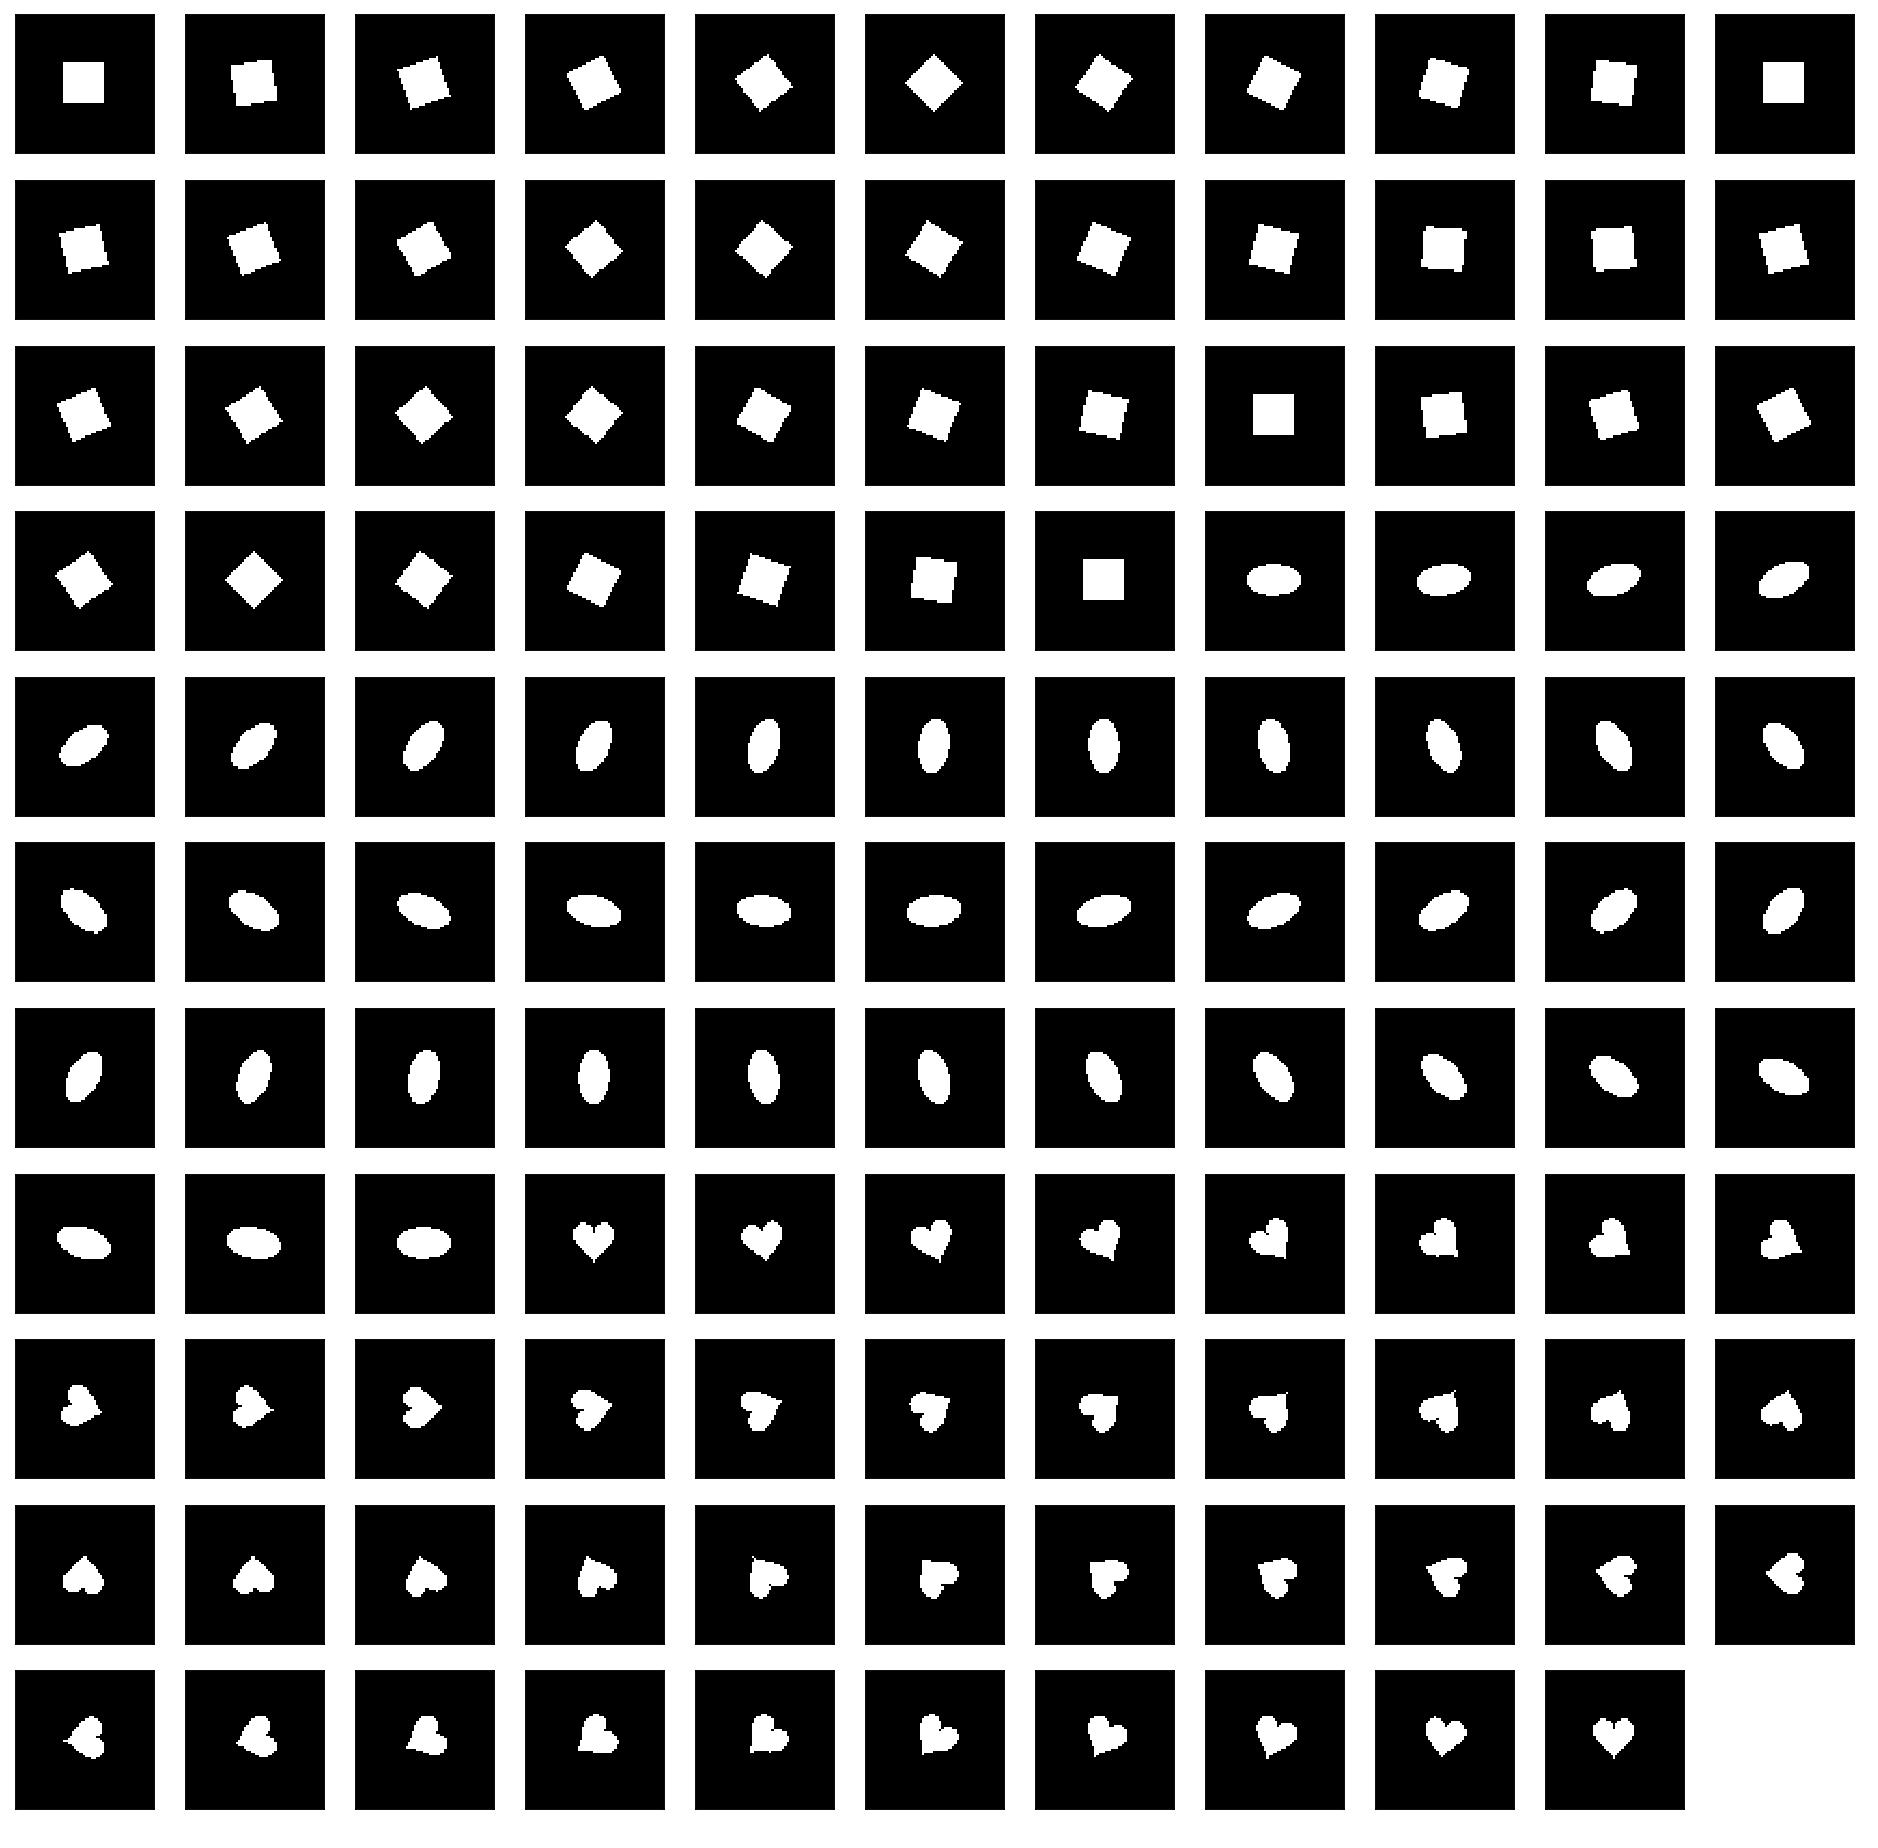

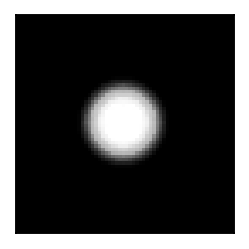

In [2]:
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                      , encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

# Define number of values per latents and functions to convert to indices
latents_sizes =  np.array([ 1,  3,  6, 40, 32, 32])
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

from copy import deepcopy
## Fix posX latent to left
#latents_sampled = sample_latent(size=5000)
latents_sampled = deepcopy(latents_classes)
latents_sampled[:, [4,5]] = 15
latents_sampled[:,2]= 5


indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[np.unique(indices_sampled)]

#np.unique(indices_sampled)

# Samples
show_images_grid(imgs_sampled,len(np.unique(indices_sampled)))

# Show the density too to check
show_density(imgs_sampled)



In [3]:
import random
random.seed(69)
ff = imgs_sampled
n_data =  ff.shape[0]
n_train = int(np.ceil(n_data*0.8))

print(n_train)
idx_train = random.sample(range(n_data), n_train)
idx_test = np.delete(range(n_data),idx_train,0)

96


In [4]:
ff.shape[0]*0.8
idx_test

array([  0,   1,   6,  14,  15,  20,  22,  23,  24,  28,  32,  43,  46,
        51,  55,  67,  85,  92,  93,  96, 104, 105, 110, 118])

In [5]:
# split data into train / validation folds
#np.random.seed(42)

img_rows = ff.shape[1]
img_cols = ff.shape[2]

n_pixels = img_rows * img_cols
x_train = ff[idx_train]
x_test = ff[idx_test]

In [6]:
x_train[1,30]
x_train[1,30].astype('float32')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [8]:
x_train.shape

(96, 4096)

In [9]:
x_train[1,2400]

1.0

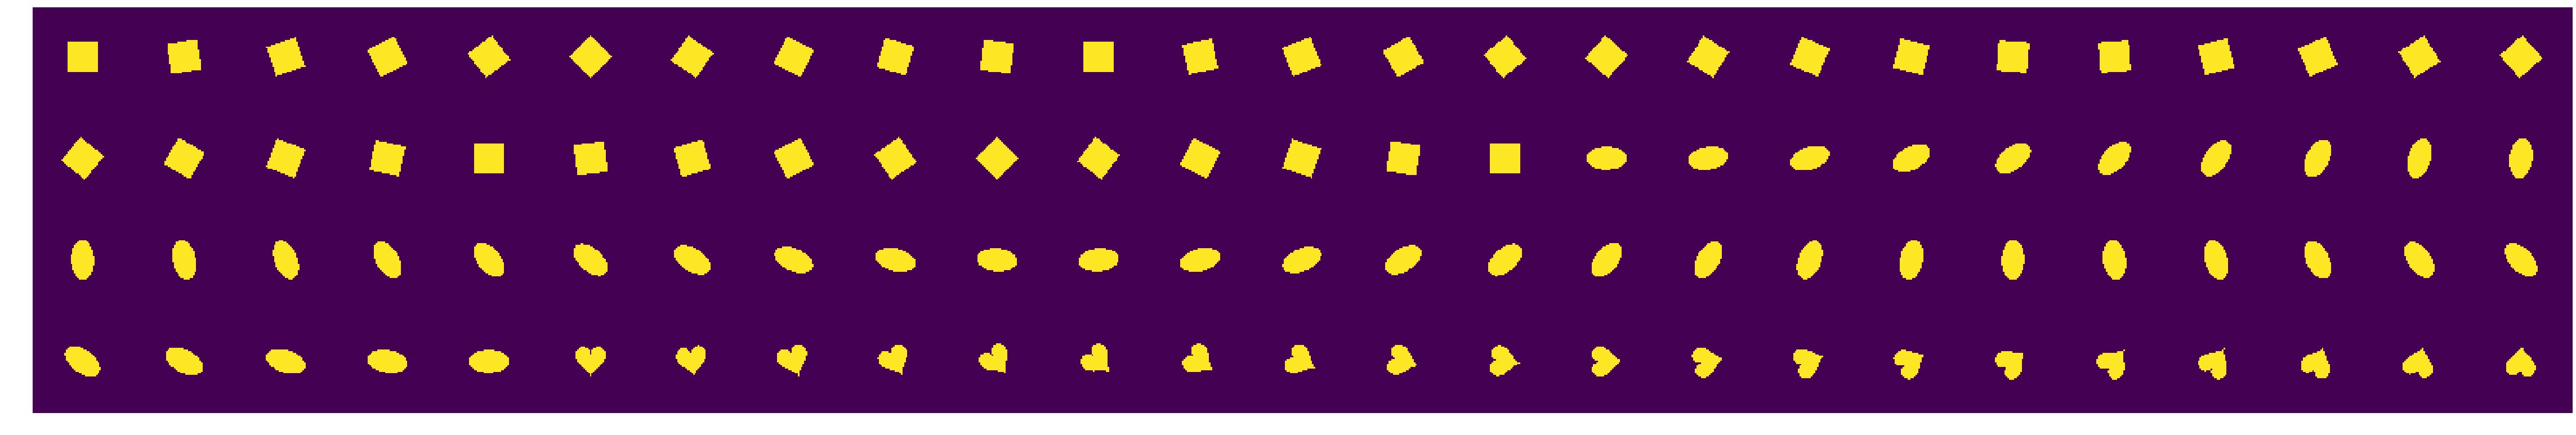

In [10]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(64, 64))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=100, n_cols=25)

In [11]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [12]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [13]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    #digit_size = 28
    img_rows, img_cols = 64, 64
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [14]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 512
intermediate_dim2 = 256
intermediate_dim3 = 64

batch_size = 20
latent_dim = 3
epochs = 100

In [15]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [16]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [17]:
# z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [18]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [19]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 3)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
Total params: 2,249,728
Trainable params: 2,249,728
Non-trainable params: 0
_________________________________________________________________


In [20]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [21]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 2245830   
_________________________________________________________________
decoder (Model)              (None, 4096)              2249728   
Total params: 4,495,558
Trainable params: 4,495,558
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs = int(1E3)

In [23]:
from keras.callbacks import ModelCheckpoint

'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
#model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_test, Y_test), callbacks=[checkpointer])
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None), 
        callbacks=[checkpointer])

Train on 96 samples, validate on 24 samples
Epoch 1/1000
96/96 [==============================] - 1s 9ms/step - loss: 2687.4142 - val_loss: 1838.1569

Epoch 00001: val_loss improved from inf to 1838.15692, saving model to weights.hdf5
Epoch 2/1000
96/96 [==============================] - 0s 485us/step - loss: 1081.5974 - val_loss: 792.5629

Epoch 00002: val_loss improved from 1838.15692 to 792.56292, saving model to weights.hdf5
Epoch 3/1000
96/96 [==============================] - 0s 401us/step - loss: 607.2873 - val_loss: 407.9268

Epoch 00003: val_loss improved from 792.56292 to 407.92676, saving model to weights.hdf5
Epoch 4/1000
96/96 [==============================] - 0s 456us/step - loss: 330.5405 - val_loss: 312.5671

Epoch 00004: val_loss improved from 407.92676 to 312.56710, saving model to weights.hdf5
Epoch 5/1000
96/96 [==============================] - 0s 429us/step - loss: 294.5449 - val_loss: 253.2273

Epoch 00005: val_loss improved from 312.56710 to 253.22729, saving m

96/96 [==============================] - 0s 449us/step - loss: 180.1587 - val_loss: 189.4681

Epoch 00045: val_loss improved from 191.12110 to 189.46811, saving model to weights.hdf5
Epoch 46/1000
96/96 [==============================] - 0s 449us/step - loss: 181.2884 - val_loss: 188.8204

Epoch 00046: val_loss improved from 189.46811 to 188.82044, saving model to weights.hdf5
Epoch 47/1000
96/96 [==============================] - 0s 467us/step - loss: 178.5674 - val_loss: 187.4672

Epoch 00047: val_loss improved from 188.82044 to 187.46724, saving model to weights.hdf5
Epoch 48/1000
96/96 [==============================] - 0s 458us/step - loss: 178.2035 - val_loss: 186.3403

Epoch 00048: val_loss improved from 187.46724 to 186.34027, saving model to weights.hdf5
Epoch 49/1000
96/96 [==============================] - 0s 462us/step - loss: 176.7290 - val_loss: 186.3687

Epoch 00049: val_loss did not improve from 186.34027
Epoch 50/1000
96/96 [==============================] - 0s 493us/s


Epoch 00089: val_loss did not improve from 103.62184
Epoch 90/1000
96/96 [==============================] - 0s 515us/step - loss: 76.7404 - val_loss: 102.9592

Epoch 00090: val_loss improved from 103.62184 to 102.95919, saving model to weights.hdf5
Epoch 91/1000
96/96 [==============================] - 0s 479us/step - loss: 75.5697 - val_loss: 103.4564

Epoch 00091: val_loss did not improve from 102.95919
Epoch 92/1000
96/96 [==============================] - 0s 496us/step - loss: 74.0695 - val_loss: 101.3452

Epoch 00092: val_loss improved from 102.95919 to 101.34520, saving model to weights.hdf5
Epoch 93/1000
96/96 [==============================] - 0s 427us/step - loss: 72.7655 - val_loss: 101.2195

Epoch 00093: val_loss improved from 101.34520 to 101.21945, saving model to weights.hdf5
Epoch 94/1000
96/96 [==============================] - 0s 439us/step - loss: 74.0440 - val_loss: 101.2881

Epoch 00094: val_loss did not improve from 101.21945
Epoch 95/1000
96/96 [=================

96/96 [==============================] - 0s 532us/step - loss: 51.3007 - val_loss: 91.7568

Epoch 00139: val_loss did not improve from 91.05134
Epoch 140/1000
96/96 [==============================] - 0s 565us/step - loss: 51.2402 - val_loss: 94.7694

Epoch 00140: val_loss did not improve from 91.05134
Epoch 141/1000
96/96 [==============================] - 0s 551us/step - loss: 50.6290 - val_loss: 90.4698

Epoch 00141: val_loss improved from 91.05134 to 90.46977, saving model to weights.hdf5
Epoch 142/1000
96/96 [==============================] - 0s 486us/step - loss: 49.9418 - val_loss: 88.9884

Epoch 00142: val_loss improved from 90.46977 to 88.98845, saving model to weights.hdf5
Epoch 143/1000
96/96 [==============================] - 0s 476us/step - loss: 48.5216 - val_loss: 91.9493

Epoch 00143: val_loss did not improve from 88.98845
Epoch 144/1000
96/96 [==============================] - 0s 484us/step - loss: 47.8479 - val_loss: 92.2962

Epoch 00144: val_loss did not improve from 

96/96 [==============================] - 0s 552us/step - loss: 38.3020 - val_loss: 97.3359

Epoch 00190: val_loss did not improve from 87.81872
Epoch 191/1000
96/96 [==============================] - 0s 544us/step - loss: 39.1030 - val_loss: 96.2405

Epoch 00191: val_loss did not improve from 87.81872
Epoch 192/1000
96/96 [==============================] - 0s 565us/step - loss: 37.0734 - val_loss: 93.3019

Epoch 00192: val_loss did not improve from 87.81872
Epoch 193/1000
96/96 [==============================] - 0s 504us/step - loss: 36.4817 - val_loss: 91.8143

Epoch 00193: val_loss did not improve from 87.81872
Epoch 194/1000
96/96 [==============================] - 0s 557us/step - loss: 36.1467 - val_loss: 91.0728

Epoch 00194: val_loss did not improve from 87.81872
Epoch 195/1000
96/96 [==============================] - 0s 546us/step - loss: 36.7420 - val_loss: 95.5575

Epoch 00195: val_loss did not improve from 87.81872
Epoch 196/1000
96/96 [==============================] - 0s 54


Epoch 00241: val_loss did not improve from 87.81872
Epoch 242/1000
96/96 [==============================] - 0s 539us/step - loss: 27.6514 - val_loss: 102.8707

Epoch 00242: val_loss did not improve from 87.81872
Epoch 243/1000
96/96 [==============================] - 0s 542us/step - loss: 27.8383 - val_loss: 100.4422

Epoch 00243: val_loss did not improve from 87.81872
Epoch 244/1000
96/96 [==============================] - 0s 566us/step - loss: 27.7101 - val_loss: 105.2209

Epoch 00244: val_loss did not improve from 87.81872
Epoch 245/1000
96/96 [==============================] - 0s 544us/step - loss: 27.7592 - val_loss: 101.8936

Epoch 00245: val_loss did not improve from 87.81872
Epoch 246/1000
96/96 [==============================] - 0s 547us/step - loss: 27.3796 - val_loss: 105.2238

Epoch 00246: val_loss did not improve from 87.81872
Epoch 247/1000
96/96 [==============================] - 0s 543us/step - loss: 26.4979 - val_loss: 99.6093

Epoch 00247: val_loss did not improve fr

96/96 [==============================] - 0s 554us/step - loss: 22.8085 - val_loss: 116.7095

Epoch 00293: val_loss did not improve from 87.81872
Epoch 294/1000
96/96 [==============================] - 0s 536us/step - loss: 23.8250 - val_loss: 123.2394

Epoch 00294: val_loss did not improve from 87.81872
Epoch 295/1000
96/96 [==============================] - 0s 546us/step - loss: 27.1115 - val_loss: 111.5031

Epoch 00295: val_loss did not improve from 87.81872
Epoch 296/1000
96/96 [==============================] - 0s 544us/step - loss: 25.9582 - val_loss: 115.7689

Epoch 00296: val_loss did not improve from 87.81872
Epoch 297/1000
96/96 [==============================] - 0s 544us/step - loss: 25.3958 - val_loss: 114.2510

Epoch 00297: val_loss did not improve from 87.81872
Epoch 298/1000
96/96 [==============================] - 0s 538us/step - loss: 26.1286 - val_loss: 126.1458

Epoch 00298: val_loss did not improve from 87.81872
Epoch 299/1000
96/96 [==============================] -

96/96 [==============================] - 0s 549us/step - loss: 19.4036 - val_loss: 122.9498

Epoch 00344: val_loss did not improve from 87.81872
Epoch 345/1000
96/96 [==============================] - 0s 557us/step - loss: 18.8338 - val_loss: 124.2744

Epoch 00345: val_loss did not improve from 87.81872
Epoch 346/1000
96/96 [==============================] - 0s 533us/step - loss: 18.1453 - val_loss: 114.5870

Epoch 00346: val_loss did not improve from 87.81872
Epoch 347/1000
96/96 [==============================] - 0s 566us/step - loss: 17.4683 - val_loss: 118.6635

Epoch 00347: val_loss did not improve from 87.81872
Epoch 348/1000
96/96 [==============================] - 0s 543us/step - loss: 18.1559 - val_loss: 114.0998

Epoch 00348: val_loss did not improve from 87.81872
Epoch 349/1000
96/96 [==============================] - 0s 552us/step - loss: 17.4992 - val_loss: 113.0152

Epoch 00349: val_loss did not improve from 87.81872
Epoch 350/1000
96/96 [==============================] -

96/96 [==============================] - 0s 539us/step - loss: 16.7447 - val_loss: 127.4945

Epoch 00395: val_loss did not improve from 87.81872
Epoch 396/1000
96/96 [==============================] - 0s 548us/step - loss: 17.9056 - val_loss: 131.3566

Epoch 00396: val_loss did not improve from 87.81872
Epoch 397/1000
96/96 [==============================] - 0s 530us/step - loss: 17.2245 - val_loss: 143.1051

Epoch 00397: val_loss did not improve from 87.81872
Epoch 398/1000
96/96 [==============================] - 0s 551us/step - loss: 17.5590 - val_loss: 144.5640

Epoch 00398: val_loss did not improve from 87.81872
Epoch 399/1000
96/96 [==============================] - 0s 541us/step - loss: 17.4338 - val_loss: 140.7586

Epoch 00399: val_loss did not improve from 87.81872
Epoch 400/1000
96/96 [==============================] - 0s 544us/step - loss: 19.6349 - val_loss: 142.1407

Epoch 00400: val_loss did not improve from 87.81872
Epoch 401/1000
96/96 [==============================] -

96/96 [==============================] - 0s 529us/step - loss: 15.5852 - val_loss: 135.9928

Epoch 00446: val_loss did not improve from 87.81872
Epoch 447/1000
96/96 [==============================] - 0s 535us/step - loss: 14.9456 - val_loss: 122.5180

Epoch 00447: val_loss did not improve from 87.81872
Epoch 448/1000
96/96 [==============================] - 0s 559us/step - loss: 15.4038 - val_loss: 129.8685

Epoch 00448: val_loss did not improve from 87.81872
Epoch 449/1000
96/96 [==============================] - 0s 548us/step - loss: 15.1290 - val_loss: 127.6704

Epoch 00449: val_loss did not improve from 87.81872
Epoch 450/1000
96/96 [==============================] - 0s 549us/step - loss: 15.7135 - val_loss: 129.7372

Epoch 00450: val_loss did not improve from 87.81872
Epoch 451/1000
96/96 [==============================] - 0s 528us/step - loss: 14.9866 - val_loss: 136.1246

Epoch 00451: val_loss did not improve from 87.81872
Epoch 452/1000
96/96 [==============================] -

96/96 [==============================] - 0s 537us/step - loss: 15.8683 - val_loss: 139.9252

Epoch 00497: val_loss did not improve from 87.81872
Epoch 498/1000
96/96 [==============================] - 0s 561us/step - loss: 16.1829 - val_loss: 136.8491

Epoch 00498: val_loss did not improve from 87.81872
Epoch 499/1000
96/96 [==============================] - 0s 537us/step - loss: 14.1028 - val_loss: 145.1787

Epoch 00499: val_loss did not improve from 87.81872
Epoch 500/1000
96/96 [==============================] - 0s 533us/step - loss: 14.4717 - val_loss: 152.2119

Epoch 00500: val_loss did not improve from 87.81872
Epoch 501/1000
96/96 [==============================] - 0s 543us/step - loss: 14.0088 - val_loss: 145.3086

Epoch 00501: val_loss did not improve from 87.81872
Epoch 502/1000
96/96 [==============================] - 0s 561us/step - loss: 14.3052 - val_loss: 156.4610

Epoch 00502: val_loss did not improve from 87.81872
Epoch 503/1000
96/96 [==============================] -

96/96 [==============================] - 0s 532us/step - loss: 17.9421 - val_loss: 134.8406

Epoch 00548: val_loss did not improve from 87.81872
Epoch 549/1000
96/96 [==============================] - 0s 549us/step - loss: 16.3842 - val_loss: 122.8278

Epoch 00549: val_loss did not improve from 87.81872
Epoch 550/1000
96/96 [==============================] - 0s 534us/step - loss: 16.4278 - val_loss: 131.9617

Epoch 00550: val_loss did not improve from 87.81872
Epoch 551/1000
96/96 [==============================] - 0s 547us/step - loss: 15.0772 - val_loss: 131.4810

Epoch 00551: val_loss did not improve from 87.81872
Epoch 552/1000
96/96 [==============================] - 0s 549us/step - loss: 14.6209 - val_loss: 121.4891

Epoch 00552: val_loss did not improve from 87.81872
Epoch 553/1000
96/96 [==============================] - 0s 551us/step - loss: 13.2458 - val_loss: 130.4143

Epoch 00553: val_loss did not improve from 87.81872
Epoch 554/1000
96/96 [==============================] -

96/96 [==============================] - 0s 540us/step - loss: 13.3533 - val_loss: 140.4437

Epoch 00599: val_loss did not improve from 87.81872
Epoch 600/1000
96/96 [==============================] - 0s 552us/step - loss: 13.1785 - val_loss: 125.4422

Epoch 00600: val_loss did not improve from 87.81872
Epoch 601/1000
96/96 [==============================] - 0s 563us/step - loss: 12.0711 - val_loss: 147.7184

Epoch 00601: val_loss did not improve from 87.81872
Epoch 602/1000
96/96 [==============================] - 0s 537us/step - loss: 12.3835 - val_loss: 131.1894

Epoch 00602: val_loss did not improve from 87.81872
Epoch 603/1000
96/96 [==============================] - 0s 549us/step - loss: 12.1331 - val_loss: 145.1339

Epoch 00603: val_loss did not improve from 87.81872
Epoch 604/1000
96/96 [==============================] - 0s 545us/step - loss: 12.5452 - val_loss: 156.3557

Epoch 00604: val_loss did not improve from 87.81872
Epoch 605/1000
96/96 [==============================] -

96/96 [==============================] - 0s 527us/step - loss: 11.9785 - val_loss: 150.1714

Epoch 00650: val_loss did not improve from 87.81872
Epoch 651/1000
96/96 [==============================] - 0s 542us/step - loss: 11.9335 - val_loss: 145.3133

Epoch 00651: val_loss did not improve from 87.81872
Epoch 652/1000
96/96 [==============================] - 0s 534us/step - loss: 11.8460 - val_loss: 160.0594

Epoch 00652: val_loss did not improve from 87.81872
Epoch 653/1000
96/96 [==============================] - 0s 547us/step - loss: 12.3708 - val_loss: 154.3112

Epoch 00653: val_loss did not improve from 87.81872
Epoch 654/1000
96/96 [==============================] - 0s 529us/step - loss: 11.4636 - val_loss: 154.9037

Epoch 00654: val_loss did not improve from 87.81872
Epoch 655/1000
96/96 [==============================] - 0s 543us/step - loss: 11.8657 - val_loss: 177.3727

Epoch 00655: val_loss did not improve from 87.81872
Epoch 656/1000
96/96 [==============================] -

96/96 [==============================] - 0s 561us/step - loss: 14.8484 - val_loss: 168.7511

Epoch 00701: val_loss did not improve from 87.81872
Epoch 702/1000
96/96 [==============================] - 0s 546us/step - loss: 15.0944 - val_loss: 157.0925

Epoch 00702: val_loss did not improve from 87.81872
Epoch 703/1000
96/96 [==============================] - 0s 552us/step - loss: 14.4519 - val_loss: 160.7304

Epoch 00703: val_loss did not improve from 87.81872
Epoch 704/1000
96/96 [==============================] - 0s 551us/step - loss: 13.0303 - val_loss: 163.5156

Epoch 00704: val_loss did not improve from 87.81872
Epoch 705/1000
96/96 [==============================] - 0s 555us/step - loss: 13.7301 - val_loss: 153.4360

Epoch 00705: val_loss did not improve from 87.81872
Epoch 706/1000
96/96 [==============================] - 0s 530us/step - loss: 14.5434 - val_loss: 156.2065

Epoch 00706: val_loss did not improve from 87.81872
Epoch 707/1000
96/96 [==============================] -

96/96 [==============================] - 0s 575us/step - loss: 20.6733 - val_loss: 161.8547

Epoch 00752: val_loss did not improve from 87.81872
Epoch 753/1000
96/96 [==============================] - 0s 561us/step - loss: 35.4006 - val_loss: 195.5609

Epoch 00753: val_loss did not improve from 87.81872
Epoch 754/1000
96/96 [==============================] - 0s 523us/step - loss: 46.8210 - val_loss: 260.2275

Epoch 00754: val_loss did not improve from 87.81872
Epoch 755/1000
96/96 [==============================] - 0s 533us/step - loss: 54.9085 - val_loss: 233.1690

Epoch 00755: val_loss did not improve from 87.81872
Epoch 756/1000
96/96 [==============================] - 0s 549us/step - loss: 48.3628 - val_loss: 219.2035

Epoch 00756: val_loss did not improve from 87.81872
Epoch 757/1000
96/96 [==============================] - 0s 535us/step - loss: 61.8446 - val_loss: 170.0514

Epoch 00757: val_loss did not improve from 87.81872
Epoch 758/1000
96/96 [==============================] -

96/96 [==============================] - 0s 551us/step - loss: 11.0955 - val_loss: 132.0826

Epoch 00803: val_loss did not improve from 87.81872
Epoch 804/1000
96/96 [==============================] - 0s 552us/step - loss: 11.2770 - val_loss: 159.6700

Epoch 00804: val_loss did not improve from 87.81872
Epoch 805/1000
96/96 [==============================] - 0s 519us/step - loss: 10.7077 - val_loss: 157.8790

Epoch 00805: val_loss did not improve from 87.81872
Epoch 806/1000
96/96 [==============================] - 0s 527us/step - loss: 11.0643 - val_loss: 136.3095

Epoch 00806: val_loss did not improve from 87.81872
Epoch 807/1000
96/96 [==============================] - 0s 539us/step - loss: 10.9614 - val_loss: 157.8309

Epoch 00807: val_loss did not improve from 87.81872
Epoch 808/1000
96/96 [==============================] - 0s 534us/step - loss: 11.2108 - val_loss: 148.4944

Epoch 00808: val_loss did not improve from 87.81872
Epoch 809/1000
96/96 [==============================] -

96/96 [==============================] - 0s 558us/step - loss: 11.2722 - val_loss: 149.5862

Epoch 00854: val_loss did not improve from 87.81872
Epoch 855/1000
96/96 [==============================] - 0s 536us/step - loss: 11.1985 - val_loss: 166.8099

Epoch 00855: val_loss did not improve from 87.81872
Epoch 856/1000
96/96 [==============================] - 0s 539us/step - loss: 10.8043 - val_loss: 160.5762

Epoch 00856: val_loss did not improve from 87.81872
Epoch 857/1000
96/96 [==============================] - 0s 530us/step - loss: 11.5275 - val_loss: 166.3970

Epoch 00857: val_loss did not improve from 87.81872
Epoch 858/1000
96/96 [==============================] - 0s 539us/step - loss: 11.6503 - val_loss: 155.3446

Epoch 00858: val_loss did not improve from 87.81872
Epoch 859/1000
96/96 [==============================] - 0s 527us/step - loss: 11.5776 - val_loss: 133.8733

Epoch 00859: val_loss did not improve from 87.81872
Epoch 860/1000
96/96 [==============================] -

96/96 [==============================] - 0s 555us/step - loss: 11.1869 - val_loss: 154.8429

Epoch 00905: val_loss did not improve from 87.81872
Epoch 906/1000
96/96 [==============================] - 0s 530us/step - loss: 11.3231 - val_loss: 174.7449

Epoch 00906: val_loss did not improve from 87.81872
Epoch 907/1000
96/96 [==============================] - 0s 544us/step - loss: 12.3165 - val_loss: 186.8538

Epoch 00907: val_loss did not improve from 87.81872
Epoch 908/1000
96/96 [==============================] - 0s 528us/step - loss: 11.8704 - val_loss: 165.9483

Epoch 00908: val_loss did not improve from 87.81872
Epoch 909/1000
96/96 [==============================] - 0s 518us/step - loss: 11.0055 - val_loss: 166.4275

Epoch 00909: val_loss did not improve from 87.81872
Epoch 910/1000
96/96 [==============================] - 0s 555us/step - loss: 11.0555 - val_loss: 148.8279

Epoch 00910: val_loss did not improve from 87.81872
Epoch 911/1000
96/96 [==============================] -

96/96 [==============================] - 0s 532us/step - loss: 10.6107 - val_loss: 162.3293

Epoch 00956: val_loss did not improve from 87.81872
Epoch 957/1000
96/96 [==============================] - 0s 530us/step - loss: 11.0309 - val_loss: 163.6185

Epoch 00957: val_loss did not improve from 87.81872
Epoch 958/1000
96/96 [==============================] - 0s 546us/step - loss: 10.9823 - val_loss: 151.8517

Epoch 00958: val_loss did not improve from 87.81872
Epoch 959/1000
96/96 [==============================] - 0s 537us/step - loss: 11.5709 - val_loss: 168.4185

Epoch 00959: val_loss did not improve from 87.81872
Epoch 960/1000
96/96 [==============================] - 0s 509us/step - loss: 10.9874 - val_loss: 195.7079

Epoch 00960: val_loss did not improve from 87.81872
Epoch 961/1000
96/96 [==============================] - 0s 530us/step - loss: 12.7816 - val_loss: 177.4341

Epoch 00961: val_loss did not improve from 87.81872
Epoch 962/1000
96/96 [==============================] -

In [24]:
z_output = sess.run( z_mean, feed_dict={'encoder_input: 0':x_train})

In [25]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([-0.01929458,  0.06869002, -0.00900903], dtype=float32)

In [26]:
np.cov(z_output.T)

array([[1.819688  , 0.15810818, 0.05383771],
       [0.15810818, 1.77326946, 0.20359517],
       [0.05383771, 0.20359517, 1.84243953]])

Plot the Pearson correlation among Z

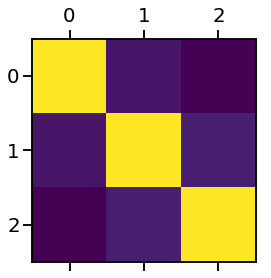

In [27]:
plt.matshow(np.corrcoef(z_output.T))

In [28]:
z_m_m

array([-0.01929458,  0.06869002, -0.00900903], dtype=float32)

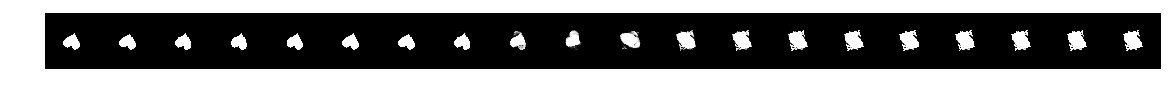

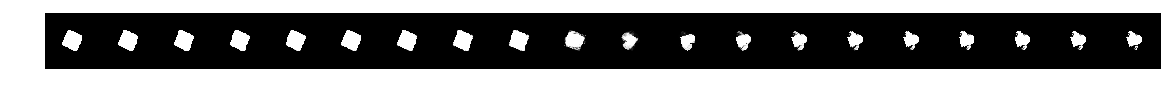

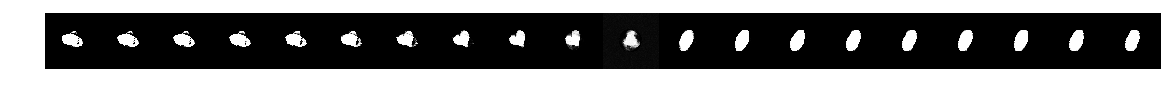

In [29]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")